##### Imports:
Import packages and load modells

In [2]:
from collections import Counter

import numpy as np
import spacy
from spacy import displacy
from spacy.lang.de import German
from spacy.lang.de.stop_words import STOP_WORDS
from matplotlib import pyplot as plt
import re

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import pyLDAvis.sklearn

import string


from enum import Enum

nlp = spacy.load('de_core_news_md')


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


##### Preprocessing and structure:

In [3]:
class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5


In [11]:
def all_statistics(party: Party):
    with open('resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l.rstrip() for l in txt)
    text = nlp(file)
    words = [token.lemma_ for token in text
             if not (token.is_stop
                     or token.is_punct
                     or token.is_space
                     or token.like_num
                     or token.like_url
                     or token.like_email
                     or token.is_currency
                     or token.text.upper() == party.name
                     or token.pos_ == 'VBZ'  # Verb, 3rd person singular present
                     or token.pos_ == 'ADP'  # adposition
                     or token.pos_ == 'PRON'  # pronoun
                     or token.pos_ == 'AUX'  # auxiliary
                     or token.text == '>'
                     or (party == Party.FDP and (token.text == 'Freie' or token.text == 'Demokraten'))
                     or not re.match('[\x00-\x7F]+', token.text))]  # remove non ascii
    word_freq = Counter(words)
    most_freq_nouns = word_freq.most_common(50)
    words_as_text = " ".join([word for word in words])
    return text, words, word_freq, most_freq_nouns, words_as_text

NameError: name 'Party' is not defined

Gather statistics for all parties

In [5]:
# statistics_tuple = (text, words, word_freq, most_freq_nouns, words_as_text)
statistics = {}

for party in Party:
    statistics[party] = all_statistics(party)

print('Loading statistics is finished!')


Loading statistics is finished!


##### Plotting:

In [6]:
def plottingPng(most_freq_words, name, show_plot=True, save_plot=False):
    ranked_frequencies = []
    x_axis = []
    y_axis = []

    for i, word in zip(range(len(most_freq_words)), most_freq_words):
        ranked_frequencies.insert(i, word)


    i = 0
    for (x, y) in ranked_frequencies:
        x_axis.insert(i, x)
        y_axis.insert(i, y)
        i += 1

    y = np.arange(50)
    plt.rcParams['figure.autolayout'] = True
    fig, ax = plt.subplots()
    ax.bar(y, y_axis, .5, color='blue')
    ax.set_xticks(y, labels=x_axis, rotation=45, ha='right')

    ax.tick_params(labelcolor='white')

    fig.set_figwidth(fig.get_figwidth() * 2)
    plt.title(name, color='white')

    if save_plot:
        plt.savefig('graphs/graph_' + name + '.svg', format='svg')
    if show_plot:
        plt.show()

Plot the most frequent words for all parties

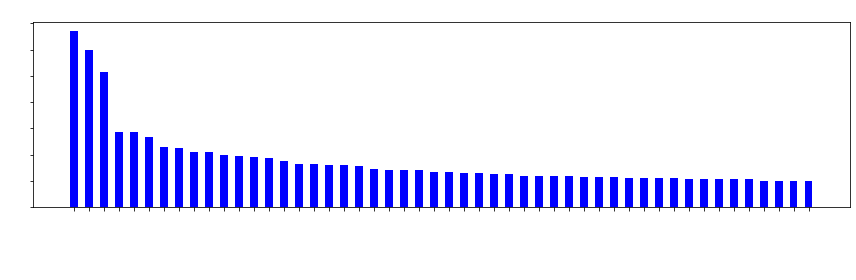

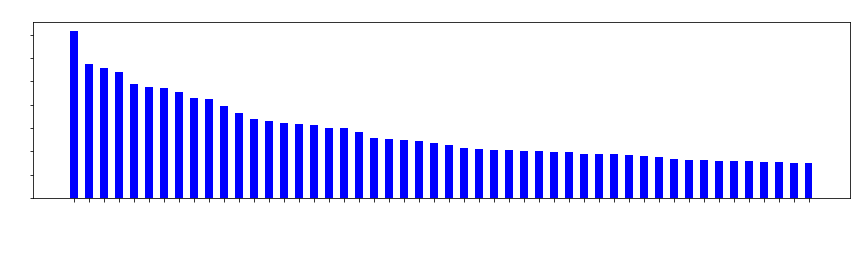

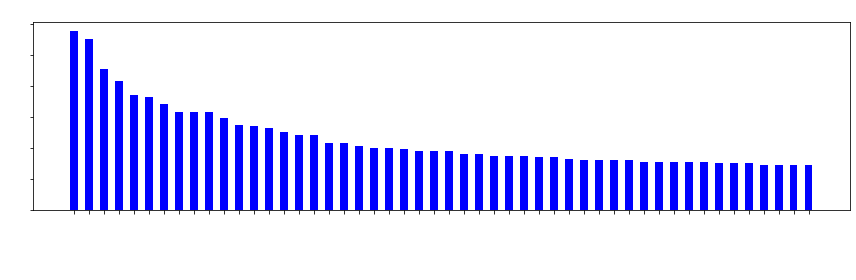

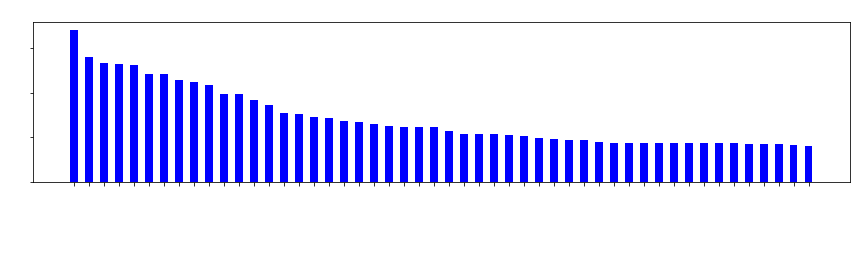

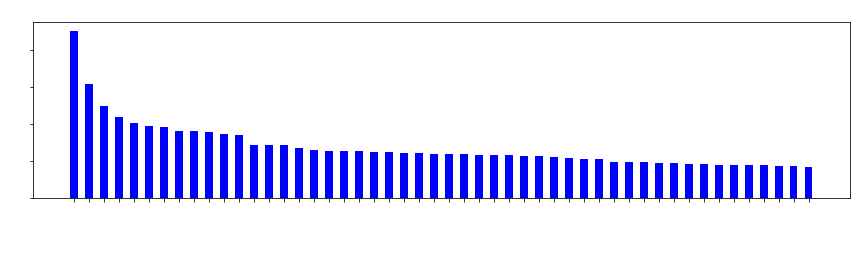

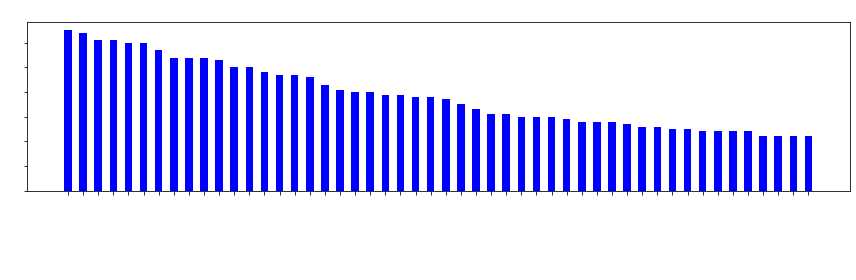

In [7]:
for party in Party:
    plottingPng(statistics[party][3], party.name)


In [3]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [4]:
with open('resources/GRUENE.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l.rstrip() for l in txt)

#file = nlp(file)
#spacy.displacy.render(doc, style='ent',jupyter=True)

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

# review = str(" ".join([i.lemma_ for i in doc]))
#
# doc = nlp(review)
# spacy.displacy.render(doc, style='ent',jupyter=True)

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    print("A",mytokens)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens



vectorizer = CountVectorizer(min_df=.9, max_df=5, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorizer_FDP = vectorizer.fit_transform([spacy_tokenizer(file)])

NUM_TOPICS = 10

lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorizer_FDP)

nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorizer_FDP)

lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorizer_FDP)

print("LDA Model:")
selected_topics(lda, vectorizer)

print("NMF Model:")
selected_topics(nmf, vectorizer)

print("LSI Model:")
selected_topics(lsi, vectorizer)

pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorizer_FDP, vectorizer, mds='tsne')
dash

<>:26: DeprecationWarning: invalid escape sequence \-
<>:26: DeprecationWarning: invalid escape sequence \-
<>:26: DeprecationWarning: invalid escape sequence \-
/tmp/ipykernel_8578/4073864193.py:26: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=.9, max_df=5, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


A  EINE EINLADUNG  Liebe Wählerinnen und Wähler, durch Wahlen entscheidet eine Gesellschaft, wer sie sein will. Das gilt erst recht für diese Bundestagswahl am 26. September. Mit ihr endet eine Ära, und eine neue kann beginnen. Zukunft ist aber nichts, was uns einfach widerfährt. Sie, liebe Wählerinnen und Wähler, können mit Ihrer Stimme selbst entscheiden, welche Richtung sie nimmt. Wir, BÜNDNIS 90/Die Grünen, legen mit diesem Programm unser inhaltliches Angebot an Sie vor. Wir tun dies in einer Zeit des globalen Ausnahmezustands. Die Pandemie hat uns alle bis ins Mark getroffen. Sie hat im Guten gezeigt, zu welcher Gemeinsamkeit, Innovationskraft und Widerstandsfähigkeit wir Menschen fähig sind. Sie hat aber auch die Schwachstellen unserer Gesellschaft schonungslos offengelegt, und das in einer ohnehin verwundbaren Welt. Die globalen Krisen dieser Zeit – zuallererst die Klimakrise als wahre Menschheitskrise – wirken in unser aller Leben hinein und gefährden Freiheit, Sicherheit und 

/home/delta/.local/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/home/delta/.local/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/delta/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LDA Model:
Topic 0:
[('innen', 213.5607337094933), ('europ', 134.60199790774243), ('mensch', 130.9871705531538), ('all', 120.71333162024689), ('rken', 111.48563397782091), ('ndnis', 111.11479388630553), ('tzen', 109.38775727128441), ('brauchen', 108.04140857040761), ('nen', 102.782124151624), ('bundestagswahl', 94.54107108464137)]
Topic 1:
[('brauchen', 0.9571216461798344), ('mensch', 0.8841596643470314), ('innen', 0.8554168795446471), ('nen', 0.7399401458257627), ('land', 0.7328846447638245), ('all', 0.72254367582369), ('unterst', 0.7127746699049906), ('europ', 0.7001489641656552), ('ndnis', 0.6665188913276173), ('bundestagswahl', 0.6263895604346902)]
Topic 2:
[('innen', 0.8435638869698278), ('brauchen', 0.83682358261605), ('europ', 0.7858335750854775), ('mensch', 0.7562485382690811), ('nen', 0.7397960890427088), ('all', 0.7213646095082052), ('ndnis', 0.621839881688369), ('bundestagswahl', 0.6180331674106198), ('rken', 0.6097937836356503), ('programmentwurf', 0.609724830145919)]
Topic

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/delta/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/delta/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/delta/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances 

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  99.996488
4       0.648955  71.707100       2        1   0.000390
6      71.019684   9.971006       3        1   0.000390
3       3.785981  33.185135       4        1   0.000390
8     -42.666500  -9.222070       5        1   0.000390
5      -3.621689 -43.526516       6        1   0.000390
1      -3.632402  -4.171708       7        1   0.000390
2     -36.584400  35.804413       8        1   0.000390
7      44.391380  50.615383       9        1   0.000390
9      40.235809 -31.591665      10        1   0.000390, topic_info=              Term        Freq       Total Category  logprob  loglift
3285         innen  250.000000  250.000000  Default  30.0000  30.0000
4228        mensch  153.000000  153.000000  Default  29.0000  29.0000
2144         europ  157.000000  157.000000  Default  28.0000  28.0000
174            all  141.000000  141.000000  Default  27.0000  27.0000
4576         ndnis  130.000000  130.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
2840       glichen    0.000019   66.272199  Topic10  -8.5494  -2.5918
3396          isch    0.000020   90.712006  Topic10  -8.5422  -2.8986
2718  gesellschaft    0.000019   61.772768  Topic10  -8.5592  -2.5313
3671       kommune    0.000019   46.359712  Topic10  -8.5733  -2.2583
2846        global    0.000019   44.598344  Topic10  -8.5936  -2.2399

[676 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
3         1  0.793422        -betreuung
12        1  0.816091  -grenzausgleichs
16        1  0.798289         -menschen
19        1  0.821401              -not
47        1  0.790987       abendschule
...     ...       ...               ...
7458      1  0.830027       zugverkehrs
7463      1  1.005436           zukunft
7467      1  0.824137   zukunftschancen
7514      1  0.816911      zusammensein
7522      1  0.840504          zuschuss

[380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 7, 4, 9, 6, 2, 3, 8, 10])